In [1]:
import os, time, copy, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchvision import models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.backends.cudnn.benchmark = True

Device: cuda


In [ ]:
work_dir = os.path.abspath("..")  
data_dir = os.path.join(work_dir, "dataprocess", "augmented")   # 你的增强数据
save_dir = os.path.join(work_dir, "Mobilenetv3-Large","checkpoints") # 模型保存路径
result_dir = os.path.join(work_dir,"Mobilenetv3-Large","results")  # 结果保存路径
os.makedirs(save_dir, exist_ok=True)

print("当前工作目录:", work_dir)
print("数据增强目录:", data_dir)
print("模型保存目录:", save_dir)
print("模型结果目录:", result_dir)

num_classes = len([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,d))])
print("类别数:", num_classes)

当前工作目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork
数据增强目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\dataprocess\augmented
模型保存目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\cnn_models\checkpoints
模型结果目录: e:\1.code\Jupyter-notebook\MUST-DataScience\1-groupwork\cnn_models\results
类别数: 8


In [3]:
CFG = {
    "model_name": "mobilenet_v3_large",   # "mobilenet_v3_large", "efficientnet_b0", "efficientnet_b3"
    "img_size": 224,
    "batch_size": 32,     # 32,16
    "stage1_epochs": 10,      # 阶段1：只训练分类头
    "stage2_epochs": 15,      # 阶段2：微调所有层
    "lr_stage1": 1e-3,        # 阶段1学习率
    "lr_stage2": 1e-4,        # 阶段2学习率（降低10倍）
    "weight_decay": 1e-4,
    "num_workers": 4,
    "save_path": save_dir,
    "result_path": result_dir,
    "accumulation_steps": 1,  # 如果显存小可 >1 做梯度累积
    "early_stopping_patience":8,  # 提前停止的耐心值
    "use_mixup": False,       # 关闭mixup
}

In [4]:
# data trasnsforms
from torchvision import datasets, transforms
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

# datasets 加载全集不划分
full_dataset = datasets.ImageFolder(
    root=data_dir, #已经离线增强了
    transform=data_transforms["train"]  # train与val transform不同
)

# 划分训练集和验证集
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = data_transforms["val"]  #  val 的 transform

# dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["batch_size"],
    shuffle=True,              # 关键：训练集必须打乱
    num_workers=CFG["num_workers"],
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG["batch_size"],
    shuffle=False,             # 验证集不打乱
    num_workers=CFG["num_workers"],
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Train Batch: {len(train_loader)}")
print(f"Val Batch: {len(val_loader)}")

Train samples: 2288
Val samples: 572
Classes: ['Cherry', 'Cucumber', 'Pearl_millet(bajra)', 'Tobacco-plant', 'banana', 'cotton', 'maize', 'wheat']
Train Batch: 72
Val Batch: 18


In [ ]:
from torchvision.models import mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights

# 加载预训练模型
weight = MobileNet_V3_Large_Weights.DEFAULT
model = mobilenet_v3_large(weights=weight)

print(model)  # 原始的MobileNetV3Large 模型结构

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [5]:
from torchvision.models import mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights

# 加载预训练模型
weight = MobileNet_V3_Large_Weights.DEFAULT
model = mobilenet_v3_large(weights=weight)

for param in model.features.parameters():
    param.requires_grad = False #冻结梯度 冻结backbone特征提取层参数

in_features = model.classifier[0].in_features
# 关键：完全替换分类头
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),  #out_features1280 -> 512
    nn.BatchNorm1d(512),  #批标准化
    nn.ReLU(inplace=True), #ReLU激活
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),  #out_features 512 -> 256
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    
    nn.Linear(256, num_classes) #最终分类层 out_features 512 -> 256
)
print(model)
model = model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
def train_epoch_no_mixup(model, train_loader, criterion, optimizer, device):
    """
    训练一个epoch - 不使用Mixup
    （用于对比测试）
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc="Training (No Mixup)")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # 前向传播 - 直接使用原始样本和标签
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        pbar.set_postfix({'loss': running_loss / total_samples})
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [15]:
def validate_epoch(model, val_loader, criterion, device):
    """验证一个epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
            
            pbar.set_postfix({'loss': running_loss / total_samples})
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [16]:
class EarlyStopping:
    """早停机制"""
    def __init__(self, patience=8, delta=0.001, best_model_path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.best_model_path = best_model_path
        self.best_epoch = 0
        
    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, epoch)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, epoch)
        
        return self.counter >= self.patience
    
    def save_checkpoint(self, model, epoch):
        torch.save(model.state_dict(), self.best_model_path)
        self.best_epoch = epoch

In [17]:
def train_two_stage_no_mixup(model, train_loader, val_loader, device, CFG):
    """
    两步走训练策略 - 不使用Mixup
    Stage 1: 冻结backbone，只训练分类头
    Stage 2: 解冻所有层，微调整个模型
    """
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    total_epochs = CFG["stage1_epochs"] + CFG["stage2_epochs"]
    
    # ========== 阶段1：只训练分类头 ==========
    print("\n" + "="*70)
    print(f"阶段1: 训练分类头 (Backbone冻结，无Mixup)")
    print(f"超参数 - 学习率: {CFG['lr_stage1']}, Epochs: {CFG['stage1_epochs']}")
    print("="*70)
    
    optimizer1 = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=CFG["lr_stage1"],
        weight_decay=CFG["weight_decay"]
    )
    
    scheduler1 = optim.lr_scheduler.CosineAnnealingLR(
        optimizer1, 
        T_max=CFG["stage1_epochs"]
    )
    
    early_stopping1 = EarlyStopping(
        patience=CFG["early_stopping_patience"],
        best_model_path=os.path.join(CFG["save_path"], "best_model_stage1_no_mixup.pth")
    )
    
    for epoch in range(CFG["stage1_epochs"]):
        print(f"\n[Epoch {epoch+1}/{CFG['stage1_epochs']}]")
        
        # 关键：调用无Mixup的训练函数
        train_loss, train_acc = train_epoch_no_mixup(model, train_loader, criterion, optimizer1, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler1.step()
        current_lr = optimizer1.param_groups[0]['lr']
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"LR: {current_lr:.6f}")
        
        if early_stopping1(val_loss, model, epoch):
            print(f" 早停触发 (第{epoch+1}个epoch，最优epoch: {early_stopping1.best_epoch+1})")
            break
    
    # ========== 阶段2：微调所有层 ==========
    print("\n" + "="*70)
    print(f"阶段2: 微调所有层 (解冻所有参数，无Mixup)")
    print(f"超参数 - 学习率: {CFG['lr_stage2']}, Epochs: {CFG['stage2_epochs']}")
    print("="*70)
    
    # 解冻所有参数
    for param in model.parameters():
        param.requires_grad = True
    
    print("✓ 已解冻所有参数")
    
    optimizer2 = optim.AdamW(
        model.parameters(),
        lr=CFG["lr_stage2"],
        weight_decay=CFG["weight_decay"]
    )
    
    scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer2,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=False,
        min_lr=1e-6
    )
    
    early_stopping2 = EarlyStopping(
        patience=CFG["early_stopping_patience"],
        best_model_path=os.path.join(CFG["save_path"], "best_model_no_mixup.pth")
    )
    
    for epoch in range(CFG["stage2_epochs"]):
        print(f"\n[Epoch {CFG['stage1_epochs']+epoch+1}/{total_epochs}]")
        
        # 关键：调用无Mixup的训练函数
        train_loss, train_acc = train_epoch_no_mixup(model, train_loader, criterion, optimizer2, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler2.step(val_loss)
        current_lr = optimizer2.param_groups[0]['lr']
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"LR: {current_lr:.6f}")
        
        if early_stopping2(val_loss, model, epoch):
            print(f" 早停触发 (第{epoch+1}个epoch，最优epoch: {CFG['stage1_epochs'] + early_stopping2.best_epoch+1})")
            break
    
    return history

In [19]:
# 训练模型
history_no_mixup = train_two_stage_no_mixup(model, train_loader, val_loader, device, CFG)


阶段1: 训练分类头 (Backbone冻结，无Mixup)
超参数 - 学习率: 0.001, Epochs: 10

[Epoch 1/10]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.59it/s, loss=0.172]


Train - Loss: 0.5439, Acc: 0.8693
Val   - Loss: 0.1720, Acc: 0.9703
LR: 0.000976

[Epoch 2/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s, loss=0.0412]


Train - Loss: 0.0795, Acc: 0.9895
Val   - Loss: 0.0412, Acc: 0.9878
LR: 0.000905

[Epoch 3/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s, loss=0.00915]


Train - Loss: 0.0507, Acc: 0.9904
Val   - Loss: 0.0091, Acc: 1.0000
LR: 0.000794

[Epoch 4/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s, loss=0.00611]


Train - Loss: 0.0339, Acc: 0.9939
Val   - Loss: 0.0061, Acc: 1.0000
LR: 0.000655

[Epoch 5/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s, loss=0.00382]


Train - Loss: 0.0203, Acc: 0.9969
Val   - Loss: 0.0038, Acc: 1.0000
LR: 0.000500

[Epoch 6/10]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.64it/s, loss=0.00306]


Train - Loss: 0.0147, Acc: 0.9978
Val   - Loss: 0.0031, Acc: 1.0000
LR: 0.000345

[Epoch 7/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s, loss=0.00282]


Train - Loss: 0.0125, Acc: 0.9987
Val   - Loss: 0.0028, Acc: 1.0000
LR: 0.000206

[Epoch 8/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s, loss=0.00222]


Train - Loss: 0.0132, Acc: 0.9983
Val   - Loss: 0.0022, Acc: 1.0000
LR: 0.000095

[Epoch 9/10]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s, loss=0.00235]


Train - Loss: 0.0093, Acc: 0.9991
Val   - Loss: 0.0023, Acc: 1.0000
LR: 0.000024

[Epoch 10/10]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s, loss=0.00221]
e:\anaconda\envs\pyt23\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train - Loss: 0.0081, Acc: 0.9991
Val   - Loss: 0.0022, Acc: 1.0000
LR: 0.000000

阶段2: 微调所有层 (解冻所有参数，无Mixup)
超参数 - 学习率: 0.0001, Epochs: 15
✓ 已解冻所有参数

[Epoch 11/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s, loss=0.00115]


Train - Loss: 0.0101, Acc: 0.9991
Val   - Loss: 0.0012, Acc: 1.0000
LR: 0.000100

[Epoch 12/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s, loss=0.0014] 


Train - Loss: 0.0083, Acc: 0.9983
Val   - Loss: 0.0014, Acc: 1.0000
LR: 0.000100

[Epoch 13/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s, loss=0.000875]


Train - Loss: 0.0087, Acc: 0.9983
Val   - Loss: 0.0009, Acc: 1.0000
LR: 0.000100

[Epoch 14/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s, loss=0.000431]


Train - Loss: 0.0055, Acc: 1.0000
Val   - Loss: 0.0004, Acc: 1.0000
LR: 0.000100

[Epoch 15/25]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s, loss=0.000322]


Train - Loss: 0.0038, Acc: 0.9996
Val   - Loss: 0.0003, Acc: 1.0000
LR: 0.000100

[Epoch 16/25]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.59it/s, loss=0.000278]


Train - Loss: 0.0027, Acc: 1.0000
Val   - Loss: 0.0003, Acc: 1.0000
LR: 0.000100

[Epoch 17/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s, loss=0.000153]


Train - Loss: 0.0021, Acc: 1.0000
Val   - Loss: 0.0002, Acc: 1.0000
LR: 0.000100

[Epoch 18/25]


Validating: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s, loss=0.00499]


Train - Loss: 0.0041, Acc: 0.9991
Val   - Loss: 0.0050, Acc: 0.9983
LR: 0.000100

[Epoch 19/25]


Validating: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s, loss=0.000254]

Train - Loss: 0.0040, Acc: 0.9996
Val   - Loss: 0.0003, Acc: 1.0000
LR: 0.000100
 早停触发 (第9个epoch，最优epoch: 11)


In [22]:
# 加载最优模型
best_model_path = os.path.join(CFG["save_path"], "best_model_no_mixup.pth")
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

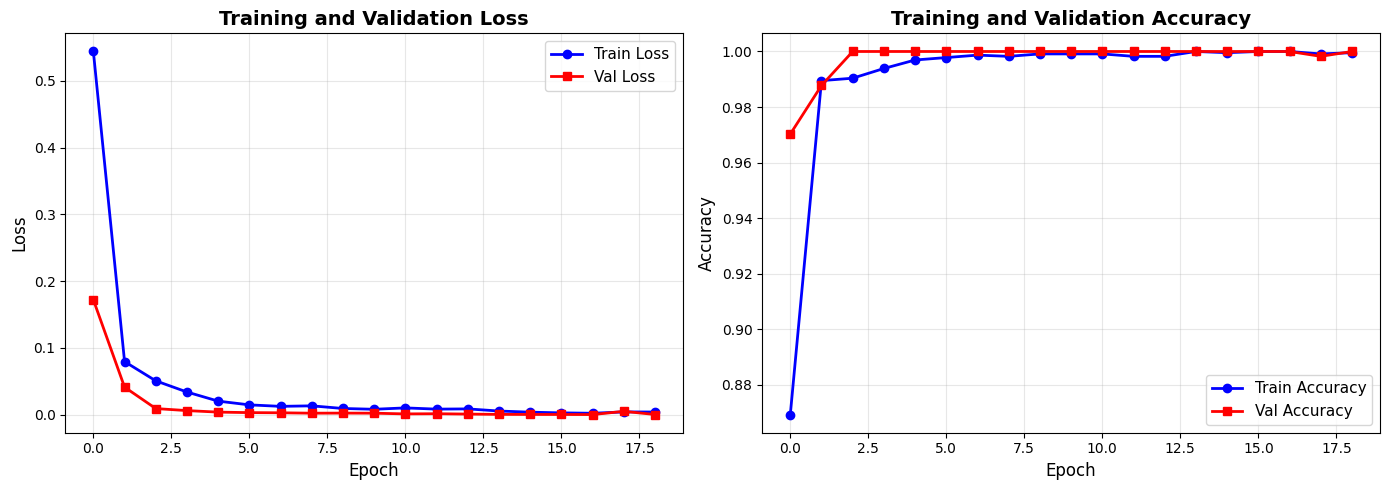

In [23]:
# 绘制训练曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss曲线
axes[0].plot(history_no_mixup['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
axes[0].plot(history_no_mixup['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy曲线
axes[1].plot(history_no_mixup['train_acc'], 'b-', label='Train Accuracy', linewidth=2, marker='o')
axes[1].plot(history_no_mixup['val_acc'], 'r-', label='Val Accuracy', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CFG["result_path"], 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

In [24]:
def evaluate_model(model, val_loader, device, class_names):
    """评估模型"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

preds, labels = evaluate_model(model, val_loader, device, full_dataset.classes)

# 分类报告
print("\n分类报告:")
print(classification_report(labels, preds, target_names=full_dataset.classes))



Evaluating: 100%|██████████| 18/18 [00:11<00:00,  1.60it/s]


分类报告:
                     precision    recall  f1-score   support

             Cherry       1.00      1.00      1.00        80
           Cucumber       1.00      1.00      1.00        75
Pearl_millet(bajra)       1.00      1.00      1.00        91
      Tobacco-plant       1.00      1.00      1.00        70
             banana       1.00      1.00      1.00        57
             cotton       1.00      1.00      1.00        67
              maize       1.00      1.00      1.00        58
              wheat       1.00      1.00      1.00        74

           accuracy                           1.00       572
          macro avg       1.00      1.00      1.00       572
       weighted avg       1.00      1.00      1.00       572



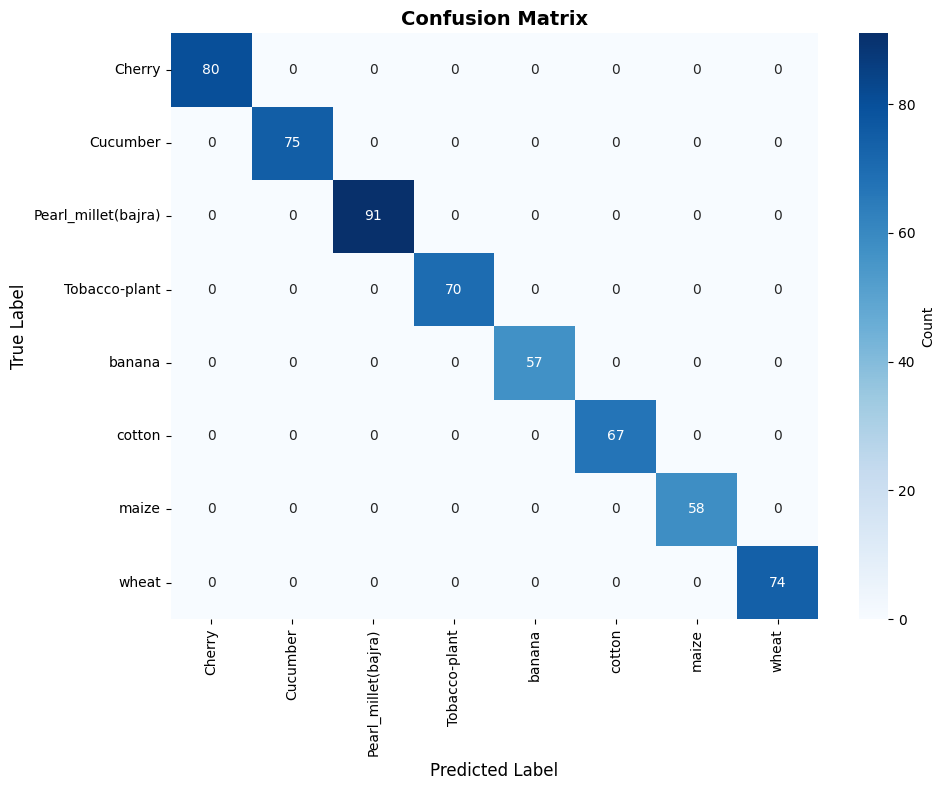

In [25]:
# 混淆矩阵
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CFG["result_path"], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

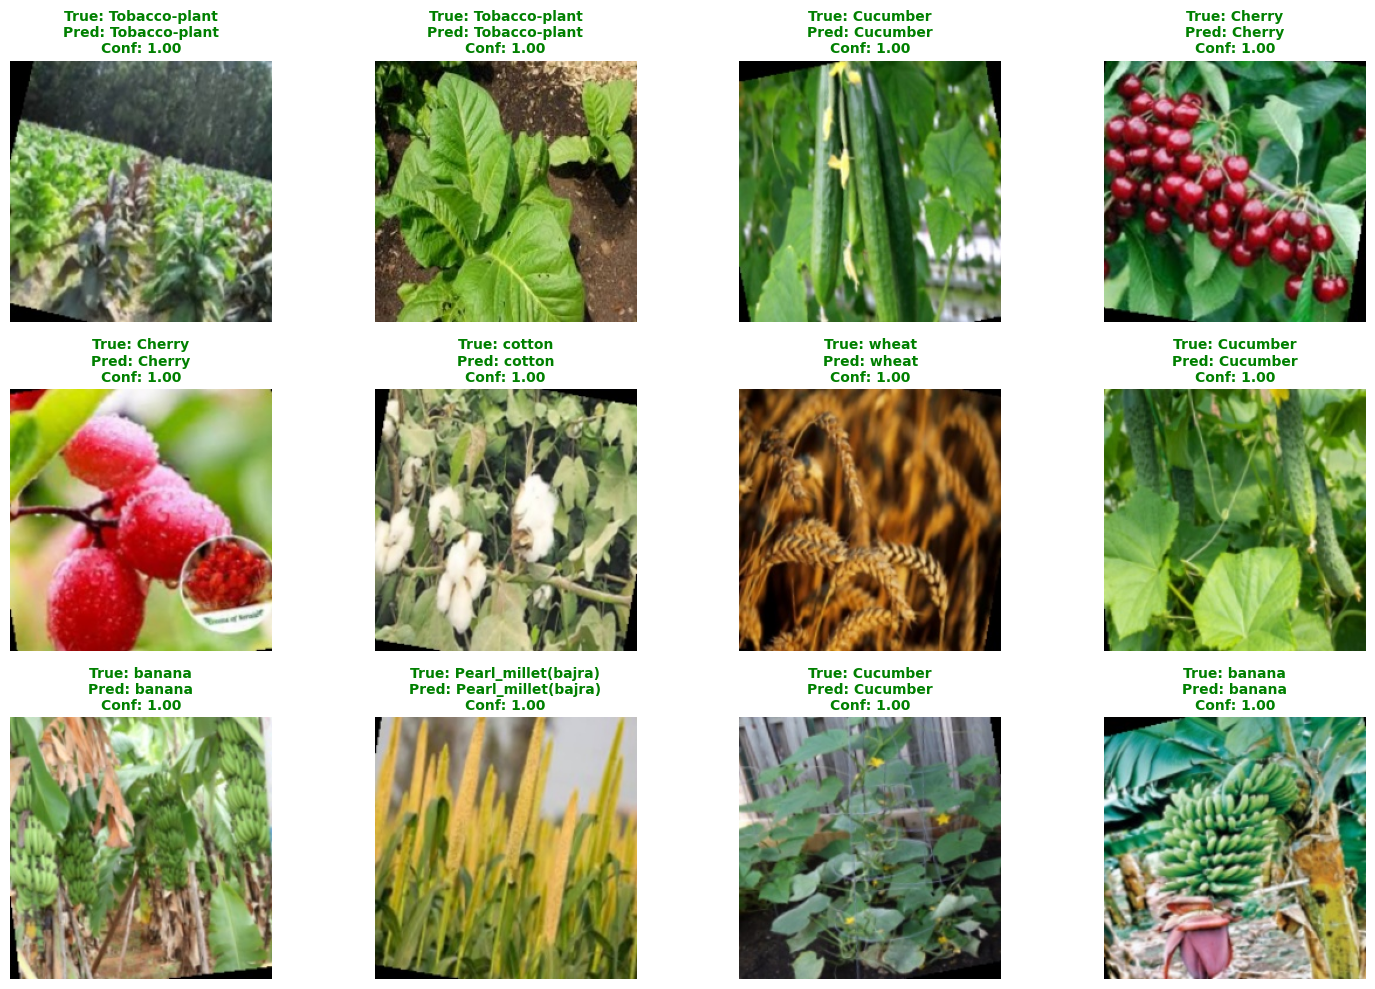

In [26]:
def visualize_predictions(model, val_loader, device, class_names, num_samples=12):
    """展示模型预测结果"""
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.ravel()
    
    with torch.no_grad():
        for images, labels in val_loader:
            if images_shown >= num_samples:
                break
            
            images_gpu = images.to(device)
            outputs = model(images_gpu)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                
                # 反标准化显示
                img = images[i].cpu()
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                      torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)
                
                ax = axes[images_shown]
                ax.imshow(img.permute(1, 2, 0))
                
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                color = 'green' if true_label == pred_label else 'red'
                confidence = torch.nn.functional.softmax(outputs, dim=1)[i].max().item()
                
                ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                           color=color, fontweight='bold', fontsize=10)
                ax.axis('off')
                
                images_shown += 1
    
    for i in range(images_shown, num_samples):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CFG["result_path"], 'predictions_visualization.png'), dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, val_loader, device, full_dataset.classes, num_samples=12)



In [27]:
# 在加载数据时添加这段代码
train_paths = set()
val_paths = set()

for img_path, _ in train_dataset:
    train_paths.add(img_path)

for img_path, _ in val_dataset:
    val_paths.add(img_path)

# 检查重叠
overlap = train_paths & val_paths
if overlap:
    print(f" 发现{len(overlap)}个重叠文件！")
else:
    print(" 无数据泄露")

 无数据泄露


In [28]:
# 检查每个类在train/val的分布
from collections import Counter

train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

print("训练集类别分布:", Counter(train_labels))
print("验证集类别分布:", Counter(val_labels))
# 如果某个类别分布严重不平衡，说明random_split()出问题了

训练集类别分布: Counter({2: 338, 3: 293, 5: 285, 4: 284, 6: 283, 0: 272, 7: 267, 1: 266})
验证集类别分布: Counter({2: 91, 0: 80, 1: 75, 7: 74, 3: 70, 5: 67, 6: 58, 4: 57})


In [30]:
def diagnose_training(history):
    """
    诊断训练过程：检测过拟合、欠拟合、标签泄露等问题
    """
    train_loss = np.array(history['train_loss'])
    val_loss = np.array(history['val_loss'])
    train_acc = np.array(history['train_acc'])
    val_acc = np.array(history['val_acc'])
    
    print("\n 关键指标分析：\n")
    
    # 1. 最终精度
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    print(f"  最终精度：")
    print(f"   Train Acc: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Val Acc:   {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    
    # 2. 精度差距（过拟合指标）
    acc_gap = final_train_acc - final_val_acc
    print(f"\n  精度差距 (Train - Val): {acc_gap:.4f}")
    if acc_gap < 0.02:
        print(f"    优秀：几乎没有过拟合")
    elif acc_gap < 0.05:
        print(f"    良好：轻微过拟合，可接受")
    elif acc_gap < 0.10:
        print(f"     中等：存在过拟合，需注意")
    else:
        print(f"    严重：明显过拟合")
    
    # 3. 损失值分析
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    loss_gap = final_val_loss - final_train_loss
    
    print(f"\n  损失值分析：")
    print(f"   Train Loss: {final_train_loss:.4f}")
    print(f"   Val Loss:   {final_val_loss:.4f}")
    print(f"   损失差距:   {loss_gap:.4f}")
    
    if final_val_acc >= 0.99:
        print(f"\n 检测到可能的问题:")
        print(f"   ├─ 验证精度为 {final_val_acc*100:.2f}%（极高！）")
        print(f"   ├─ 原因1: 数据集分割可能不合理")
        print(f"   ├─ 原因2: 训练集和验证集有泄露（重叠）")
        print(f"   ├─ 原因3: 数据集过于简单/类别差异很大")
        print(f"   └─ 原因4: 验证集样本量太少，随机波动大")
        
        # 检测标签泄露
        if final_val_acc > 0.99 and final_train_loss > 0.3:
            print(f"\n   💡 诊断结果: 很可能存在【标签泄露】或【数据重复】")
            print(f"   数据症状: 验证集精度>99% + 训练loss>0.3")
    
    # 4. 收敛速度
    print(f"\n4️⃣  收敛速度分析：")
    first_5_avg = np.mean(train_loss[:5]) if len(train_loss) >= 5 else np.mean(train_loss)
    last_5_avg = np.mean(train_loss[-5:]) if len(train_loss) >= 5 else train_loss[-1]
    convergence_ratio = (first_5_avg - last_5_avg) / first_5_avg if first_5_avg > 0 else 0
    
    print(f"   前5个epoch平均loss: {first_5_avg:.4f}")
    print(f"   后5个epoch平均loss: {last_5_avg:.4f}")
    print(f"   收敛率: {convergence_ratio*100:.1f}%")
    
    if convergence_ratio > 0.5:
        print(f"   ✅ 快速收敛（>50%下降）")
    else:
        print(f"   ⚠️  缓慢收敛（<50%下降）")
    
    # 5. Loss趋势
    print(f"\n  损失趋势分析：")
    train_loss_trend = "下降" if train_loss[-1] < train_loss[0] else "上升"
    val_loss_trend = "下降" if val_loss[-1] < val_loss[0] else "上升"
    print(f"   Train loss趋势: {train_loss_trend}")
    print(f"   Val loss趋势:   {val_loss_trend}")
    
    # 6. 稳定性
    print(f"\n 训练稳定性分析：")
    train_acc_std = np.std(train_acc[-5:])
    val_acc_std = np.std(val_acc[-5:])
    print(f"   最后5个epoch训练精度std: {train_acc_std:.4f}")
    print(f"   最后5个epoch验证精度std: {val_acc_std:.4f}")
    
    if val_acc_std > 0.03:
        print(f"    验证精度波动较大（不稳定）")
    else:
        print(f"   验证精度稳定")

diagnose_training(history_no_mixup)


 关键指标分析：

  最终精度：
   Train Acc: 0.9996 (99.96%)
   Val Acc:   1.0000 (100.00%)

  精度差距 (Train - Val): -0.0004
    优秀：几乎没有过拟合

  损失值分析：
   Train Loss: 0.0040
   Val Loss:   0.0003
   损失差距:   -0.0037

 检测到可能的问题:
   ├─ 验证精度为 100.00%（极高！）
   ├─ 原因1: 数据集分割可能不合理
   ├─ 原因2: 训练集和验证集有泄露（重叠）
   ├─ 原因3: 数据集过于简单/类别差异很大
   └─ 原因4: 验证集样本量太少，随机波动大

4️⃣  收敛速度分析：
   前5个epoch平均loss: 0.1456
   后5个epoch平均loss: 0.0033
   收敛率: 97.7%
   ✅ 快速收敛（>50%下降）

  损失趋势分析：
   Train loss趋势: 下降
   Val loss趋势:   下降

 训练稳定性分析：
   最后5个epoch训练精度std: 0.0003
   最后5个epoch验证精度std: 0.0007
   验证精度稳定


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 